- # 128줄씩 앞에 데이터와 겹쳐서 1초씩(256줄) 분할한 데이터로 lstm을 train한 코드입니다.

# 1.bandpass

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import itertools
import time
import random

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.optim import AdamW
from torch.optim.lr_scheduler import (CosineAnnealingLR,
                                      CosineAnnealingWarmRestarts,
                                      StepLR,
                                      ExponentialLR)

from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import accuracy_score, auc, f1_score, precision_score, recall_score

In [ ]:
import tqdm, re, sys
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.metrics import plot_confusion_matrix
from keras.layers import Conv2D, Conv1D, MaxPooling2D, MaxPooling1D, Flatten, BatchNormalization, Dense
from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from keras.callbacks import CSVLogger, ModelCheckpoint

In [ ]:
data_total = pd.read_csv('/content/drive/MyDrive/model_1s_over/total_band.csv', header=None)

In [ ]:
data_total

,0,1,2,3,4,5,6,7,8,9,...,247,248,249,250,251,252,253,254,255,256
0,-0.031820,-0.015874,-0.001172,0.011249,0.020713,0.026974,0.030190,0.030831,0.029559,0.027102,...,-0.035003,-0.034647,-0.033418,-0.031305,-0.028545,-0.025565,-0.022868,-0.020891,-0.019891,1.0
1,0.401977,0.381335,0.353735,0.319320,0.278790,0.233424,0.184983,0.135520,0.087119,0.041629,...,0.268145,0.286128,0.304299,0.322373,0.339934,0.356470,0.371414,0.384183,0.394201,1.0
2,-0.019872,-0.020594,-0.021637,-0.022515,-0.022798,-0.022202,-0.020644,-0.018236,-0.015233,-0.011971,...,-0.072854,-0.070401,-0.067539,-0.064716,-0.062285,-0.060443,-0.059208,-0.058448,-0.057940,1.0
3,0.400917,0.403804,0.402367,0.396151,0.384771,0.367941,0.345523,0.317577,0.284411,0.246605,...,0.169533,0.188411,0.208027,0.227756,0.247033,0.265431,0.282711,0.298819,0.313845,1.0
4,-0.057454,-0.056822,-0.055984,-0.054985,-0.053945,-0.052999,-0.052250,-0.051733,-0.051414,-0.051213,...,-0.059447,-0.057278,-0.056011,-0.055424,-0.055246,-0.055239,-0.055275,-0.055352,-0.055577,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35995,-0.050435,-0.047843,-0.044973,-0.042221,-0.040007,-0.038694,-0.038512,-0.039513,-0.041550,-0.044289,...,-0.054704,-0.052600,-0.050564,-0.048774,-0.047331,-0.046216,-0.045292,-0.044332,-0.043089,100.0
35996,0.022090,0.024929,0.027786,0.031100,0.035075,0.039622,0.044402,0.048933,0.052740,0.055510,...,-0.053679,-0.057318,-0.059515,-0.061043,-0.062554,-0.064528,-0.067243,-0.070758,-0.074902,100.0
35997,-0.041365,-0.039069,-0.036238,-0.033035,-0.029705,-0.026536,-0.023804,-0.021728,-0.020455,-0.020042,...,-0.086279,-0.149944,-0.197480,-0.223854,-0.227829,-0.211824,-0.181055,-0.142239,-0.102183,100.0
35998,-0.079288,-0.083358,-0.086464,-0.087995,-0.087513,-0.084880,-0.080336,-0.074488,-0.068211,-0.062467,...,-0.066882,-0.067113,-0.068424,-0.070704,-0.073600,-0.076563,-0.078930,-0.080050,-0.079413,100.0


## 데이터 전체 섞기

In [ ]:
data_total=data_total.sample(frac=1)

In [ ]:
data_train=data_total.iloc[0:24000, :]
data_val=data_total.iloc[24000:30000, :]
data_test=data_total.iloc[30000:36000,:]

In [ ]:
data_train

,0,1,2,3,4,5,6,7,8,9,...,247,248,249,250,251,252,253,254,255,256
26494,0.399276,0.399971,0.397905,0.393050,0.385220,0.374073,0.359166,0.340063,0.316471,0.288371,...,-0.088677,-0.089496,-0.091399,-0.093922,-0.096456,-0.098428,-0.099463,-0.099486,-0.098721,74.0
14635,-0.050752,-0.049914,-0.047386,-0.043254,-0.037809,-0.031505,-0.024877,-0.018448,-0.012638,-0.007695,...,0.263882,0.336533,0.384489,0.399780,0.379347,0.325844,0.247231,0.155242,0.063083,41.0
9369,0.205217,0.224423,0.243682,0.261899,0.277850,0.290383,0.298643,0.302239,0.301308,0.296451,...,0.103321,0.076699,0.050887,0.026992,0.005981,-0.011447,-0.024965,-0.034673,-0.041069,27.0
10807,0.012498,0.013703,0.014238,0.014050,0.013126,0.011482,0.009162,0.006272,0.003005,-0.000344,...,0.034054,-0.010669,-0.063664,-0.117012,-0.162607,-0.193774,-0.206551,-0.200326,-0.177703,31.0
14029,-0.066531,-0.064627,-0.063030,-0.061914,-0.061393,-0.061507,-0.062217,-0.063405,-0.064876,-0.066385,...,-0.130457,-0.132733,-0.114176,-0.070501,-0.001355,0.088724,0.190272,0.289959,0.372690,39.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28524,0.004370,0.021088,0.028714,0.020196,-0.007911,-0.054665,-0.114930,-0.180482,-0.241764,-0.289866,...,0.092020,0.096739,0.101393,0.106431,0.112244,0.119090,0.127031,0.135925,0.145454,80.0
29215,0.022044,0.007300,-0.006109,-0.017900,-0.027736,-0.035316,-0.040469,-0.043234,-0.043895,-0.042978,...,-0.063862,-0.061484,-0.057876,-0.053445,-0.048766,-0.044489,-0.041212,-0.039378,-0.039188,82.0
28855,-0.744064,-0.744056,-0.730065,-0.696044,-0.639628,-0.562641,-0.470592,-0.371378,-0.273590,-0.184846,...,0.289705,0.258131,0.225338,0.192351,0.160336,0.130394,0.103355,0.079635,0.059195,81.0
10171,-0.085207,-0.086156,-0.087321,-0.088720,-0.090387,-0.092297,-0.094312,-0.096171,-0.097521,-0.098006,...,0.012481,0.009446,0.007922,0.009213,0.013614,0.020632,0.029311,0.038548,0.047362,29.0


## 전처리

In [ ]:
y_train = to_categorical(data_train[256])
y_test = to_categorical(data_test[256])
y_val = to_categorical(data_val[256])
y_train[23999]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
      dtype=float32)

In [ ]:
data_train.drop([256], axis=1, inplace=True)
data_test.drop([256], axis=1, inplace=True)
data_val.drop([256], axis=1, inplace=True)
data_train

/usr/local/lib/python3.8/dist-packages/pandas/core/frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


,0,1,2,3,4,5,6,7,8,9,...,246,247,248,249,250,251,252,253,254,255
26494,0.399276,0.399971,0.397905,0.393050,0.385220,0.374073,0.359166,0.340063,0.316471,0.288371,...,-0.089112,-0.088677,-0.089496,-0.091399,-0.093922,-0.096456,-0.098428,-0.099463,-0.099486,-0.098721
14635,-0.050752,-0.049914,-0.047386,-0.043254,-0.037809,-0.031505,-0.024877,-0.018448,-0.012638,-0.007695,...,0.177669,0.263882,0.336533,0.384489,0.399780,0.379347,0.325844,0.247231,0.155242,0.063083
9369,0.205217,0.224423,0.243682,0.261899,0.277850,0.290383,0.298643,0.302239,0.301308,0.296451,...,0.129622,0.103321,0.076699,0.050887,0.026992,0.005981,-0.011447,-0.024965,-0.034673,-0.041069
10807,0.012498,0.013703,0.014238,0.014050,0.013126,0.011482,0.009162,0.006272,0.003005,-0.000344,...,0.064341,0.034054,-0.010669,-0.063664,-0.117012,-0.162607,-0.193774,-0.206551,-0.200326,-0.177703
14029,-0.066531,-0.064627,-0.063030,-0.061914,-0.061393,-0.061507,-0.062217,-0.063405,-0.064876,-0.066385,...,-0.114044,-0.130457,-0.132733,-0.114176,-0.070501,-0.001355,0.088724,0.190272,0.289959,0.372690
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28524,0.004370,0.021088,0.028714,0.020196,-0.007911,-0.054665,-0.114930,-0.180482,-0.241764,-0.289866,...,0.086827,0.092020,0.096739,0.101393,0.106431,0.112244,0.119090,0.127031,0.135925,0.145454
29215,0.022044,0.007300,-0.006109,-0.017900,-0.027736,-0.035316,-0.040469,-0.043234,-0.043895,-0.042978,...,-0.064843,-0.063862,-0.061484,-0.057876,-0.053445,-0.048766,-0.044489,-0.041212,-0.039378,-0.039188
28855,-0.744064,-0.744056,-0.730065,-0.696044,-0.639628,-0.562641,-0.470592,-0.371378,-0.273590,-0.184846,...,0.319340,0.289705,0.258131,0.225338,0.192351,0.160336,0.130394,0.103355,0.079635,0.059195
10171,-0.085207,-0.086156,-0.087321,-0.088720,-0.090387,-0.092297,-0.094312,-0.096171,-0.097521,-0.098006,...,0.014661,0.012481,0.009446,0.007922,0.009213,0.013614,0.020632,0.029311,0.038548,0.047362


In [ ]:
X_train=data_train.values
X_test=data_test.values
X_val=data_val.values

In [ ]:
print(X_train.shape)
print(X_test.shape)
print(X_val.shape)
print(y_train.shape)
print(y_test.shape)
print(y_val.shape)

(24000, 256)
(6000, 256)
(6000, 256)
(24000, 101)
(6000, 101)
(6000, 101)


In [ ]:

X_train = X_train.reshape(24000, 256, 1)
X_test = X_test.reshape(6000, 256, 1)
X_val = X_val.reshape(6000, 256, 1)
X_train.shape, X_test.shape, X_val.shape

((24000, 256, 1), (6000, 256, 1), (6000, 256, 1))

## LSTM

In [ ]:
from keras.layers import Input, Embedding, GRU, LSTM, SimpleRNN, MaxPooling1D, GlobalMaxPool1D, CuDNNGRU
from keras.layers import Dropout, Dense, Activation, Flatten, Conv1D, SpatialDropout1D
from keras.models import Sequential

model = Sequential()
model.add(LSTM(units=100, return_sequences=True, input_shape=(256,1))) #shape[1]=열
model.add(LSTM(units=50, return_sequences=True))
model.add(LSTM(units=50, return_sequences=True))

model.add(Flatten())
model.add(Dropout(0.1))

model.add(Dense(101, activation='softmax'))
model.compile(optimizer='adam', loss='mse',metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 256, 100)          40800     
                                                                 
 lstm_1 (LSTM)               (None, 256, 50)           30200     
                                                                 
 lstm_2 (LSTM)               (None, 256, 50)           20200     
                                                                 
 flatten (Flatten)           (None, 12800)             0         
                                                                 
 dropout (Dropout)           (None, 12800)             0         
                                                                 
 dense (Dense)               (None, 101)               1292901   
                                                                 
Total params: 1,384,101
Trainable params: 1,384,101
No

## 모델학습/평가

In [ ]:
history = model.fit(X_train, y_train, batch_size = 1024, epochs = 1000, verbose = 1, validation_data=(X_val, y_val))

Epoch 1/1000
24/24 [==============================] - 13s 193ms/step - loss: 0.0098 - accuracy: 0.0095 - val_loss: 0.0098 - val_accuracy: 0.0070
Epoch 2/1000
24/24 [==============================] - 4s 150ms/step - loss: 0.0098 - accuracy: 0.0091 - val_loss: 0.0098 - val_accuracy: 0.0047
Epoch 3/1000
24/24 [==============================] - 4s 150ms/step - loss: 0.0098 - accuracy: 0.0104 - val_loss: 0.0098 - val_accuracy: 0.0097
Epoch 4/1000
24/24 [==============================] - 4s 151ms/step - loss: 0.0098 - accuracy: 0.0104 - val_loss: 0.0098 - val_accuracy: 0.0110
Epoch 5/1000
24/24 [==============================] - 4s 152ms/step - loss: 0.0098 - accuracy: 0.0113 - val_loss: 0.0098 - val_accuracy: 0.0117
Epoch 6/1000
24/24 [==============================] - 4s 152ms/step - loss: 0.0098 - accuracy: 0.0104 - val_loss: 0.0098 - val_accuracy: 0.0102
Epoch 7/1000
24/24 [==============================] - 4s 156ms/step - loss: 0.0098 - accuracy: 0.0118 - val_loss: 0.0098 - val_accuracy

In [ ]:
model.evaluate(X_test, y_test)

188/188 [==============================] - 2s 11ms/step - loss: 6.2110e-04 - accuracy: 0.9588


[0.0006210956489667296, 0.9588333368301392]

In [ ]:
model.save('bandpass_1s_over.h5')

## 그래프 분석

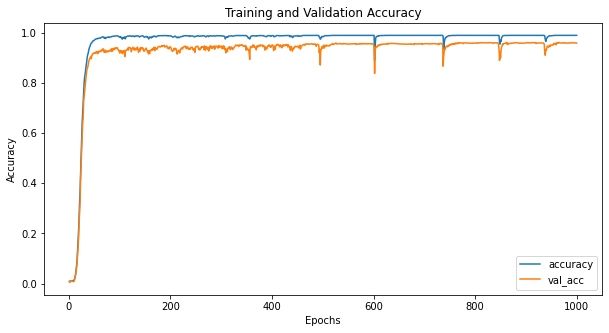

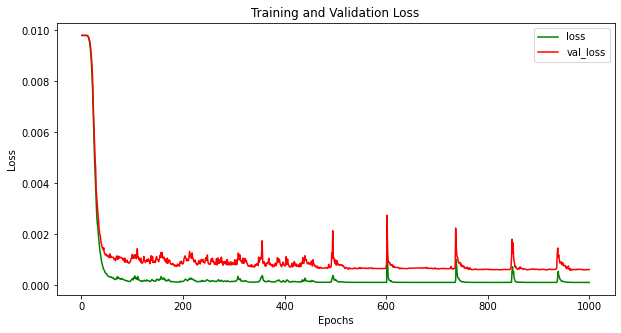

In [ ]:
history=history.history
epochs = range(1, len(history['loss']) + 1)
acc = history['accuracy']
loss = history['loss']
val_acc = history['val_accuracy']
val_loss = history['val_loss']

plt.figure(figsize=(10, 5))
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.plot(epochs, acc, label='accuracy')
plt.plot(epochs, val_acc, label='val_acc')
plt.legend()

plt.figure(figsize=(10, 5))
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.plot(epochs, loss, label='loss', color='g')
plt.plot(epochs, val_loss, label='val_loss', color='r')
plt.legend()


## 예측해보기(predict)

In [ ]:
y_pred = model.predict(X_test)

188/188 [==============================] - 3s 10ms/step


In [ ]:
y_test_p=pd.DataFrame(y_test)

for i in range(1,101):
  y_test_p.loc[y_test_p[i] == 1.0 , 'y_test'] = i  
y_test_p.y_test

0       75.0
1       90.0
2       67.0
3       91.0
4       84.0
        ... 
5995    44.0
5996    37.0
5997    99.0
5998    88.0
5999    31.0
Name: y_test, Length: 6000, dtype: float64

In [ ]:
ex=np.argmax(y_pred, axis=1)
ex=ex.astype('float64')
ex=pd.DataFrame(ex)
ex

,0
0,75.0
1,90.0
2,67.0
3,91.0
4,84.0
...,...
5995,44.0
5996,37.0
5997,99.0
5998,88.0


In [ ]:
ch1 = pd.DataFrame(np.rint(y_pred))
ch1['pred'] = ex
data_test.reset_index(inplace=True, drop=True)
predict = pd.concat([data_test,ch1['pred'], y_test_p['y_test']],axis = 1)

In [ ]:
predict['compare'] = np.where(predict['pred']==predict['y_test'],'yes', 'no')

In [ ]:
predict_1 = predict[predict["compare"]=='no']
predict_1

,0,1,2,3,4,5,6,7,8,9,...,249,250,251,252,253,254,255,pred,y_test,compare
8,0.034902,0.040244,0.046107,0.052067,0.057719,0.062743,0.066955,0.070322,0.072960,0.075095,...,0.085447,0.084625,0.083489,0.081097,0.076492,0.069015,0.058567,18.0,2.0,no
11,0.109717,0.110659,0.111964,0.114482,0.118950,0.125818,0.135116,0.146405,0.158831,0.171282,...,-0.046100,-0.047511,-0.047318,-0.046095,-0.044528,-0.043274,-0.042820,2.0,92.0,no
26,0.014270,0.001147,-0.009664,-0.017843,-0.023431,-0.026793,-0.028535,-0.029376,-0.030009,-0.030962,...,-0.023292,-0.026665,-0.030282,-0.033635,-0.035797,-0.035559,-0.031681,10.0,8.0,no
27,-0.030546,-0.028344,-0.027399,-0.027423,-0.028062,-0.029064,-0.030394,-0.032242,-0.034932,-0.038768,...,0.005832,0.002299,-0.006270,-0.020143,-0.038324,-0.058224,-0.075590,66.0,47.0,no
35,-0.025196,-0.024448,-0.023728,-0.023056,-0.022438,-0.021864,-0.021319,-0.020791,-0.020296,-0.019888,...,0.045220,0.041943,0.036367,0.029059,0.020812,0.012487,0.004854,96.0,8.0,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5904,-0.023422,-0.018496,-0.014607,-0.011922,-0.010307,-0.009338,-0.008411,-0.006905,-0.004374,-0.000691,...,-0.045415,-0.049928,-0.055818,-0.062579,-0.069229,-0.074560,-0.077474,18.0,94.0,no
5911,0.031127,0.030208,0.029620,0.029588,0.030140,0.031080,0.032028,0.032515,0.032121,0.030616,...,-0.026762,-0.027985,-0.028425,-0.028331,-0.027923,-0.027419,-0.027036,95.0,49.0,no
5943,0.063536,0.071162,0.078900,0.086882,0.095225,0.103941,0.112881,0.121710,0.129939,0.136985,...,-0.053988,-0.052298,-0.050341,-0.048330,-0.046442,-0.044802,-0.043505,29.0,42.0,no
5972,-0.043211,-0.041627,-0.039691,-0.037799,-0.036304,-0.035467,-0.035429,-0.036219,-0.037772,-0.039970,...,-0.225394,-0.183337,-0.113905,-0.020055,0.090091,0.203977,0.306470,39.0,30.0,no


# 2.highpass

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import itertools
import time
import random

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.optim import AdamW
from torch.optim.lr_scheduler import (CosineAnnealingLR,
                                      CosineAnnealingWarmRestarts,
                                      StepLR,
                                      ExponentialLR)

from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import accuracy_score, auc, f1_score, precision_score, recall_score

In [ ]:
import tqdm, re, sys
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.metrics import plot_confusion_matrix
from keras.layers import Conv2D, Conv1D, MaxPooling2D, MaxPooling1D, Flatten, BatchNormalization, Dense
from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from keras.callbacks import CSVLogger, ModelCheckpoint

In [ ]:
data_total = pd.read_csv('/content/drive/MyDrive/model_1s_over/total_high.csv', header=None)

In [ ]:
data_total

,0,1,2,3,4,5,6,7,8,9,...,247,248,249,250,251,252,253,254,255,256
0,-0.011566,0.077466,0.083038,0.015121,-0.024216,0.026618,0.112943,0.067018,-0.022367,0.035899,...,-0.080380,-0.088511,0.005901,-0.000657,-0.066214,-0.061900,-0.011674,0.064162,-0.020820,1.0
1,0.333165,0.386996,0.454338,0.324952,0.235537,0.246562,0.251469,0.160027,0.010096,0.018957,...,0.210829,0.234220,0.318602,0.388814,0.320726,0.291639,0.407233,0.422197,0.374201,1.0
2,-0.105411,0.006199,0.035219,-0.038238,-0.087385,-0.047431,0.057264,0.011541,-0.063622,-0.054354,...,-0.102607,-0.121740,-0.038993,-0.017367,-0.083201,-0.108995,-0.055099,0.004076,-0.050829,1.0
3,0.354916,0.394712,0.453208,0.405614,0.339571,0.334389,0.367986,0.384145,0.235843,0.187722,...,0.151038,0.152772,0.190335,0.298428,0.225539,0.225290,0.283660,0.335569,0.355608,1.0
4,-0.124635,-0.101820,-0.004986,-0.009573,-0.097080,-0.078287,-0.033934,0.011788,-0.100740,-0.105788,...,-0.087241,-0.110820,-0.037730,0.000719,-0.066072,-0.119163,-0.068725,0.003512,-0.040881,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35995,-0.012444,-0.030325,-0.013896,-0.007077,-0.017446,-0.022156,-0.026465,0.009467,-0.019471,-0.017068,...,-0.075817,-0.088859,-0.066459,-0.027269,-0.024837,-0.054075,-0.060061,-0.075066,-0.062740,100.0
35996,0.020267,0.062224,-0.014968,0.012301,0.073691,0.025622,0.056645,0.040058,0.073452,0.061997,...,-0.057440,-0.065800,-0.044000,-0.082399,-0.083447,-0.065335,-0.088911,-0.080017,-0.076062,100.0
35997,-0.018143,-0.060154,-0.043685,-0.038534,-0.053733,0.003980,-0.039076,-0.056911,-0.010135,-0.024207,...,-0.186225,-0.270191,-0.271967,-0.251862,-0.217607,-0.171631,-0.152646,-0.086120,-0.086904,100.0
35998,-0.091136,-0.072359,-0.082491,-0.096773,-0.108624,-0.106044,-0.096813,-0.094621,-0.049099,-0.103425,...,-0.095215,-0.045811,-0.093347,-0.052513,-0.086620,-0.069087,-0.056044,-0.095822,-0.080069,100.0


## 데이터 전체 섞기

In [ ]:
data_total=data_total.sample(frac=1)

In [ ]:
data_train=data_total.iloc[0:24000, :]
data_val=data_total.iloc[24000:30000, :]
data_test=data_total.iloc[30000:36000,:]

In [ ]:
data_train

,0,1,2,3,4,5,6,7,8,9,...,247,248,249,250,251,252,253,254,255,256
26765,-0.130145,-0.074645,-0.096633,-0.088118,-0.076931,-0.099941,-0.075619,-0.043954,-0.078897,-0.091267,...,0.032574,0.008186,0.023748,-0.011560,-0.023997,-0.036633,-0.035550,-0.037025,-0.033701,75.0
27587,-0.043680,-0.037940,-0.022230,-0.059210,-0.033820,-0.061350,-0.042720,-0.035500,-0.058620,-0.069299,...,-0.033787,-0.021377,-0.013347,-0.013088,-0.007948,-0.023948,-0.037177,0.002973,-0.051657,77.0
29647,-0.064452,-0.070540,-0.066748,-0.086005,-0.056133,-0.068741,-0.098738,-0.057676,-0.081613,-0.099950,...,-0.014457,0.014307,-0.005010,0.033634,0.058708,0.020821,0.058745,0.036128,0.022542,83.0
6865,-0.024157,-0.010111,0.001445,-0.023479,-0.009883,-0.011287,0.006139,0.008335,-0.021380,0.009186,...,0.176271,0.148957,0.154193,0.133469,0.116616,0.090982,0.050169,0.058226,0.046553,20.0
18216,0.011607,0.025221,0.004585,0.029469,-0.020217,-0.004753,0.058451,0.033675,0.079759,0.052933,...,0.142969,0.151867,0.159704,0.133623,0.099502,0.105301,0.057162,0.024092,0.013034,51.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6111,-0.075384,-0.058416,-0.032367,0.001792,-0.058957,-0.000956,-0.004795,0.059468,0.041531,0.046515,...,-0.108836,-0.120144,-0.118673,-0.128531,-0.075489,-0.078367,-0.088095,-0.097162,-0.102139,17.0
5026,-0.135453,-0.279546,-0.360368,-0.398411,-0.412473,-0.379695,-0.309567,-0.239549,-0.157650,-0.126922,...,0.061886,0.067452,0.082858,0.075784,0.079000,0.077487,0.116833,0.099620,0.117057,14.0
19528,-0.075005,-0.086588,-0.059841,-0.022823,-0.071544,-0.075095,-0.105115,-0.082975,-0.061815,-0.070304,...,0.017884,0.032572,0.076890,0.047849,0.026248,0.030587,0.069317,0.025977,0.065888,55.0
371,-0.038818,-0.027229,0.000821,-0.000229,-0.022429,-0.047919,0.016291,-0.007479,-0.029478,-0.068537,...,-0.040069,-0.097880,-0.040972,-0.008884,-0.041147,-0.049630,-0.057654,-0.040129,-0.020624,2.0


## 전처리

In [ ]:
y_train = to_categorical(data_train[256])
y_test = to_categorical(data_test[256])
y_val = to_categorical(data_val[256])
y_train[23999]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
      dtype=float32)

In [ ]:
data_train.drop([256], axis=1, inplace=True)
data_test.drop([256], axis=1, inplace=True)
data_val.drop([256], axis=1, inplace=True)
data_train

/usr/local/lib/python3.8/dist-packages/pandas/core/frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


,0,1,2,3,4,5,6,7,8,9,...,246,247,248,249,250,251,252,253,254,255
26765,-0.130145,-0.074645,-0.096633,-0.088118,-0.076931,-0.099941,-0.075619,-0.043954,-0.078897,-0.091267,...,0.032543,0.032574,0.008186,0.023748,-0.011560,-0.023997,-0.036633,-0.035550,-0.037025,-0.033701
27587,-0.043680,-0.037940,-0.022230,-0.059210,-0.033820,-0.061350,-0.042720,-0.035500,-0.058620,-0.069299,...,-0.013646,-0.033787,-0.021377,-0.013347,-0.013088,-0.007948,-0.023948,-0.037177,0.002973,-0.051657
29647,-0.064452,-0.070540,-0.066748,-0.086005,-0.056133,-0.068741,-0.098738,-0.057676,-0.081613,-0.099950,...,-0.009101,-0.014457,0.014307,-0.005010,0.033634,0.058708,0.020821,0.058745,0.036128,0.022542
6865,-0.024157,-0.010111,0.001445,-0.023479,-0.009883,-0.011287,0.006139,0.008335,-0.021380,0.009186,...,0.210025,0.176271,0.148957,0.154193,0.133469,0.116616,0.090982,0.050169,0.058226,0.046553
18216,0.011607,0.025221,0.004585,0.029469,-0.020217,-0.004753,0.058451,0.033675,0.079759,0.052933,...,0.181043,0.142969,0.151867,0.159704,0.133623,0.099502,0.105301,0.057162,0.024092,0.013034
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6111,-0.075384,-0.058416,-0.032367,0.001792,-0.058957,-0.000956,-0.004795,0.059468,0.041531,0.046515,...,-0.110577,-0.108836,-0.120144,-0.118673,-0.128531,-0.075489,-0.078367,-0.088095,-0.097162,-0.102139
5026,-0.135453,-0.279546,-0.360368,-0.398411,-0.412473,-0.379695,-0.309567,-0.239549,-0.157650,-0.126922,...,0.046710,0.061886,0.067452,0.082858,0.075784,0.079000,0.077487,0.116833,0.099620,0.117057
19528,-0.075005,-0.086588,-0.059841,-0.022823,-0.071544,-0.075095,-0.105115,-0.082975,-0.061815,-0.070304,...,0.021577,0.017884,0.032572,0.076890,0.047849,0.026248,0.030587,0.069317,0.025977,0.065888
371,-0.038818,-0.027229,0.000821,-0.000229,-0.022429,-0.047919,0.016291,-0.007479,-0.029478,-0.068537,...,-0.021908,-0.040069,-0.097880,-0.040972,-0.008884,-0.041147,-0.049630,-0.057654,-0.040129,-0.020624


In [ ]:
X_train=data_train.values
X_test=data_test.values
X_val=data_val.values

In [ ]:
print(X_train.shape)
print(X_test.shape)
print(X_val.shape)
print(y_train.shape)
print(y_test.shape)
print(y_val.shape)

(24000, 256)
(6000, 256)
(6000, 256)
(24000, 101)
(6000, 101)
(6000, 101)


In [ ]:

X_train = X_train.reshape(24000, 256, 1)
X_test = X_test.reshape(6000, 256, 1)
X_val = X_val.reshape(6000, 256, 1)
X_train.shape, X_test.shape, X_val.shape

((24000, 256, 1), (6000, 256, 1), (6000, 256, 1))

## LSTM

In [ ]:
from keras.layers import Input, Embedding, GRU, LSTM, SimpleRNN, MaxPooling1D, GlobalMaxPool1D, CuDNNGRU
from keras.layers import Dropout, Dense, Activation, Flatten, Conv1D, SpatialDropout1D
from keras.models import Sequential

model = Sequential()
model.add(LSTM(units=100, return_sequences=True, input_shape=(256,1))) #shape[1]=열
model.add(LSTM(units=50, return_sequences=True))
model.add(LSTM(units=50, return_sequences=True))

model.add(Flatten())
model.add(Dropout(0.1))

model.add(Dense(101, activation='softmax'))
model.compile(optimizer='adam', loss='mse',metrics=['accuracy'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 256, 100)          40800     
                                                                 
 lstm_4 (LSTM)               (None, 256, 50)           30200     
                                                                 
 lstm_5 (LSTM)               (None, 256, 50)           20200     
                                                                 
 flatten_1 (Flatten)         (None, 12800)             0         
                                                                 
 dropout_1 (Dropout)         (None, 12800)             0         
                                                                 
 dense_1 (Dense)             (None, 101)               1292901   
                                                                 
Total params: 1,384,101
Trainable params: 1,384,101
No

## 모델학습/평가

In [ ]:
history = model.fit(X_train, y_train, batch_size = 1024, epochs = 1000, verbose = 1, validation_data=(X_val, y_val))

Epoch 1/1000
24/24 [==============================] - 10s 222ms/step - loss: 0.0098 - accuracy: 0.0098 - val_loss: 0.0098 - val_accuracy: 0.0090
Epoch 2/1000
24/24 [==============================] - 4s 153ms/step - loss: 0.0098 - accuracy: 0.0099 - val_loss: 0.0098 - val_accuracy: 0.0095
Epoch 3/1000
24/24 [==============================] - 4s 153ms/step - loss: 0.0098 - accuracy: 0.0094 - val_loss: 0.0098 - val_accuracy: 0.0107
Epoch 4/1000
24/24 [==============================] - 4s 153ms/step - loss: 0.0098 - accuracy: 0.0112 - val_loss: 0.0098 - val_accuracy: 0.0082
Epoch 5/1000
24/24 [==============================] - 4s 153ms/step - loss: 0.0098 - accuracy: 0.0099 - val_loss: 0.0098 - val_accuracy: 0.0095
Epoch 6/1000
24/24 [==============================] - 4s 153ms/step - loss: 0.0098 - accuracy: 0.0095 - val_loss: 0.0098 - val_accuracy: 0.0082
Epoch 7/1000
24/24 [==============================] - 4s 154ms/step - loss: 0.0098 - accuracy: 0.0107 - val_loss: 0.0098 - val_accuracy

In [ ]:
model.evaluate(X_test, y_test)

188/188 [==============================] - 2s 12ms/step - loss: 8.5065e-04 - accuracy: 0.9462


[0.0008506450685672462, 0.9461666941642761]

In [ ]:
model.save('highpass_1s_over.h5')

## 그래프 분석

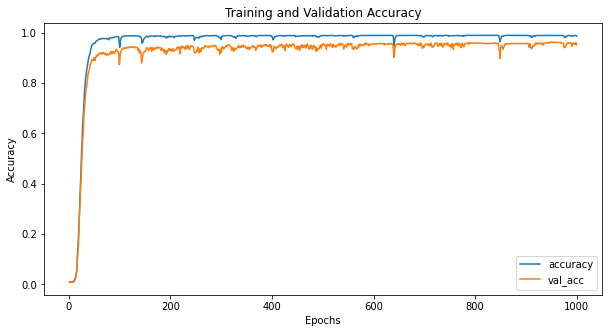

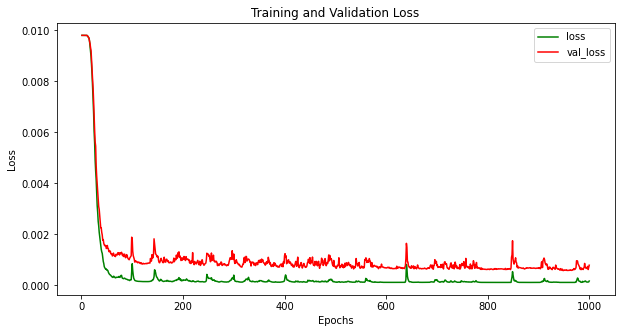

In [ ]:
history=history.history
epochs = range(1, len(history['loss']) + 1)
acc = history['accuracy']
loss = history['loss']
val_acc = history['val_accuracy']
val_loss = history['val_loss']

plt.figure(figsize=(10, 5))
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.plot(epochs, acc, label='accuracy')
plt.plot(epochs, val_acc, label='val_acc')
plt.legend()

plt.figure(figsize=(10, 5))
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.plot(epochs, loss, label='loss', color='g')
plt.plot(epochs, val_loss, label='val_loss', color='r')
plt.legend()


## 예측해보기(predict)

In [ ]:
y_pred = model.predict(X_test)

188/188 [==============================] - 3s 10ms/step


In [ ]:
y_test_p=pd.DataFrame(y_test)

for i in range(1,101):
  y_test_p.loc[y_test_p[i] == 1.0 , 'y_test'] = i  
y_test_p.y_test

0       75.0
1       90.0
2       67.0
3       91.0
4       84.0
        ... 
5995    44.0
5996    37.0
5997    99.0
5998    88.0
5999    31.0
Name: y_test, Length: 6000, dtype: float64

In [ ]:
ex=np.argmax(y_pred, axis=1)
ex=ex.astype('float64')
ex=pd.DataFrame(ex)
ex

,0
0,75.0
1,90.0
2,67.0
3,91.0
4,84.0
...,...
5995,44.0
5996,37.0
5997,99.0
5998,88.0


In [ ]:
ch1 = pd.DataFrame(np.rint(y_pred))
ch1['pred'] = ex
data_test.reset_index(inplace=True, drop=True)
predict = pd.concat([data_test,ch1['pred'], y_test_p['y_test']],axis = 1)

In [ ]:
predict['compare'] = np.where(predict['pred']==predict['y_test'],'yes', 'no')

In [ ]:
predict_1 = predict[predict["compare"]=='no']
predict_1

,0,1,2,3,4,5,6,7,8,9,...,249,250,251,252,253,254,255,pred,y_test,compare
8,0.034902,0.040244,0.046107,0.052067,0.057719,0.062743,0.066955,0.070322,0.072960,0.075095,...,0.085447,0.084625,0.083489,0.081097,0.076492,0.069015,0.058567,18.0,2.0,no
11,0.109717,0.110659,0.111964,0.114482,0.118950,0.125818,0.135116,0.146405,0.158831,0.171282,...,-0.046100,-0.047511,-0.047318,-0.046095,-0.044528,-0.043274,-0.042820,2.0,92.0,no
26,0.014270,0.001147,-0.009664,-0.017843,-0.023431,-0.026793,-0.028535,-0.029376,-0.030009,-0.030962,...,-0.023292,-0.026665,-0.030282,-0.033635,-0.035797,-0.035559,-0.031681,10.0,8.0,no
27,-0.030546,-0.028344,-0.027399,-0.027423,-0.028062,-0.029064,-0.030394,-0.032242,-0.034932,-0.038768,...,0.005832,0.002299,-0.006270,-0.020143,-0.038324,-0.058224,-0.075590,66.0,47.0,no
35,-0.025196,-0.024448,-0.023728,-0.023056,-0.022438,-0.021864,-0.021319,-0.020791,-0.020296,-0.019888,...,0.045220,0.041943,0.036367,0.029059,0.020812,0.012487,0.004854,96.0,8.0,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5904,-0.023422,-0.018496,-0.014607,-0.011922,-0.010307,-0.009338,-0.008411,-0.006905,-0.004374,-0.000691,...,-0.045415,-0.049928,-0.055818,-0.062579,-0.069229,-0.074560,-0.077474,18.0,94.0,no
5911,0.031127,0.030208,0.029620,0.029588,0.030140,0.031080,0.032028,0.032515,0.032121,0.030616,...,-0.026762,-0.027985,-0.028425,-0.028331,-0.027923,-0.027419,-0.027036,95.0,49.0,no
5943,0.063536,0.071162,0.078900,0.086882,0.095225,0.103941,0.112881,0.121710,0.129939,0.136985,...,-0.053988,-0.052298,-0.050341,-0.048330,-0.046442,-0.044802,-0.043505,29.0,42.0,no
5972,-0.043211,-0.041627,-0.039691,-0.037799,-0.036304,-0.035467,-0.035429,-0.036219,-0.037772,-0.039970,...,-0.225394,-0.183337,-0.113905,-0.020055,0.090091,0.203977,0.306470,39.0,30.0,no


# 3.lowpass

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import itertools
import time
import random

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.optim import AdamW
from torch.optim.lr_scheduler import (CosineAnnealingLR,
                                      CosineAnnealingWarmRestarts,
                                      StepLR,
                                      ExponentialLR)

from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import accuracy_score, auc, f1_score, precision_score, recall_score

In [ ]:
import tqdm, re, sys
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.metrics import plot_confusion_matrix
from keras.layers import Conv2D, Conv1D, MaxPooling2D, MaxPooling1D, Flatten, BatchNormalization, Dense
from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from keras.callbacks import CSVLogger, ModelCheckpoint

In [ ]:
data_total = pd.read_csv('/content/drive/MyDrive/model_1s_over/total_low.csv', header=None)

In [ ]:
data_total

,0,1,2,3,4,5,6,7,8,9,...,247,248,249,250,251,252,253,254,255,256
0,1.697478,1.713703,1.728594,1.741144,1.750717,1.757105,1.760490,1.761353,1.760349,1.758191,...,1.733012,1.733423,1.734708,1.736879,1.739700,1.742739,1.745491,1.747515,1.748556,1.0
1,2.157222,2.136746,2.109318,2.075073,2.034710,1.989504,1.941220,1.891914,1.843672,1.798347,...,2.038064,2.056037,2.074209,2.092290,2.109857,2.126393,2.141329,2.154079,2.164073,1.0
2,1.748610,1.747925,1.746924,1.746097,1.745874,1.746535,1.748158,1.750626,1.753678,1.756978,...,1.694451,1.696899,1.699745,1.702543,1.704941,1.706748,1.707952,1.708690,1.709187,1.0
3,2.170759,2.173616,2.172147,2.165900,2.154489,2.137630,2.115185,2.087215,2.054029,2.016211,...,1.939092,1.957995,1.977649,1.997433,2.016782,2.035266,2.052636,2.068832,2.083937,1.0
4,1.709674,1.710317,1.711171,1.712183,1.713227,1.714166,1.714897,1.715389,1.715680,1.715858,...,1.722441,1.724729,1.726115,1.726820,1.727122,1.727259,1.727362,1.727430,1.727353,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35995,1.566146,1.568872,1.571868,1.574740,1.577074,1.578513,1.578830,1.577972,1.576088,1.573504,...,1.592790,1.594984,1.597113,1.598995,1.600525,1.601719,1.602719,1.603755,1.605082,100.0
35996,1.656066,1.659062,1.662113,1.665637,1.669814,1.674541,1.679471,1.684122,1.688029,1.690891,...,1.600670,1.597018,1.594806,1.593269,1.591762,1.589812,1.587139,1.583680,1.579595,100.0
35997,1.606899,1.609297,1.612236,1.615546,1.618973,1.622223,1.625016,1.627131,1.628430,1.628864,...,1.566417,1.502800,1.455337,1.429038,1.425103,1.441076,1.471716,1.510314,1.550094,100.0
35998,1.575260,1.571225,1.568130,1.566590,1.567050,1.569659,1.574187,1.580032,1.586320,1.592084,...,1.579022,1.578733,1.577374,1.575056,1.572128,1.569131,1.566724,1.565555,1.566133,100.0


## 데이터 전체 섞기

In [ ]:
data_total=data_total.sample(frac=1)

In [ ]:
data_train=data_total.iloc[0:24000, :]
data_val=data_total.iloc[24000:30000, :]
data_test=data_total.iloc[30000:36000,:]

In [ ]:
data_train

,0,1,2,3,4,5,6,7,8,9,...,247,248,249,250,251,252,253,254,255,256
25017,1.595007,1.591732,1.590498,1.590055,1.588979,1.586122,1.581044,1.574321,1.567646,1.563684,...,1.820250,1.824994,1.828896,1.831458,1.832095,1.830238,1.825455,1.817534,1.806524,70.0
133,1.775953,1.766012,1.747591,1.721868,1.692768,1.666985,1.653282,1.661062,1.698426,1.770057,...,1.802541,1.797933,1.791330,1.783274,1.774403,1.765426,1.757121,1.750315,1.745836,1.0
16582,1.652922,1.642628,1.627187,1.607643,1.585292,1.561468,1.537345,1.513809,1.491397,1.470316,...,1.552604,1.549493,1.548325,1.549118,1.551600,1.555304,1.559687,1.564245,1.568595,47.0
6395,1.603790,1.605875,1.607365,1.608239,1.608536,1.608339,1.607762,1.606938,1.606016,1.605151,...,1.608223,1.608639,1.608725,1.608267,1.607100,1.605140,1.602417,1.599078,1.595384,18.0
5756,1.690259,1.693050,1.695618,1.697597,1.698696,1.698740,1.697707,1.695751,1.693189,1.690465,...,1.657611,1.672135,1.709933,1.773043,1.859066,1.960589,2.065692,2.159599,2.227249,16.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29000,1.582211,1.584821,1.590280,1.596815,1.601708,1.601759,1.594091,1.577204,1.552074,1.522986,...,1.820448,1.828142,1.835804,1.844218,1.854397,1.867313,1.883629,1.903512,1.926556,81.0
34737,1.648511,1.654190,1.660728,1.667548,1.673930,1.679162,1.682689,1.684244,1.683908,1.682115,...,1.829384,1.833693,1.835524,1.835857,1.835845,1.836575,1.838825,1.842888,1.848489,97.0
5440,1.797205,1.808518,1.819250,1.828837,1.836909,1.843338,1.848250,1.851976,1.854977,1.857742,...,1.703143,1.701846,1.701290,1.701487,1.702393,1.703904,1.705837,1.707931,1.709874,16.0
1916,1.657758,1.660762,1.672088,1.687368,1.702860,1.715944,1.725269,1.730606,1.732539,1.732089,...,1.716574,1.716556,1.718317,1.721936,1.726984,1.732743,1.738453,1.743483,1.747435,6.0


## 전처리

In [ ]:
y_train = to_categorical(data_train[256])
y_test = to_categorical(data_test[256])
y_val = to_categorical(data_val[256])
y_train[23999]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
      dtype=float32)

In [ ]:
data_train.drop([256], axis=1, inplace=True)
data_test.drop([256], axis=1, inplace=True)
data_val.drop([256], axis=1, inplace=True)
data_train

/usr/local/lib/python3.8/dist-packages/pandas/core/frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


,0,1,2,3,4,5,6,7,8,9,...,246,247,248,249,250,251,252,253,254,255
25017,1.595007,1.591732,1.590498,1.590055,1.588979,1.586122,1.581044,1.574321,1.567646,1.563684,...,1.814993,1.820250,1.824994,1.828896,1.831458,1.832095,1.830238,1.825455,1.817534,1.806524
133,1.775953,1.766012,1.747591,1.721868,1.692768,1.666985,1.653282,1.661062,1.698426,1.770057,...,1.804745,1.802541,1.797933,1.791330,1.783274,1.774403,1.765426,1.757121,1.750315,1.745836
16582,1.652922,1.642628,1.627187,1.607643,1.585292,1.561468,1.537345,1.513809,1.491397,1.470316,...,1.557334,1.552604,1.549493,1.548325,1.549118,1.551600,1.555304,1.559687,1.564245,1.568595
6395,1.603790,1.605875,1.607365,1.608239,1.608536,1.608339,1.607762,1.606938,1.606016,1.605151,...,1.607696,1.608223,1.608639,1.608725,1.608267,1.607100,1.605140,1.602417,1.599078,1.595384
5756,1.690259,1.693050,1.695618,1.697597,1.698696,1.698740,1.697707,1.695751,1.693189,1.690465,...,1.661228,1.657611,1.672135,1.709933,1.773043,1.859066,1.960589,2.065692,2.159599,2.227249
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29000,1.582211,1.584821,1.590280,1.596815,1.601708,1.601759,1.594091,1.577204,1.552074,1.522986,...,1.812362,1.820448,1.828142,1.835804,1.844218,1.854397,1.867313,1.883629,1.903512,1.926556
34737,1.648511,1.654190,1.660728,1.667548,1.673930,1.679162,1.682689,1.684244,1.683908,1.682115,...,1.821988,1.829384,1.833693,1.835524,1.835857,1.835845,1.836575,1.838825,1.842888,1.848489
5440,1.797205,1.808518,1.819250,1.828837,1.836909,1.843338,1.848250,1.851976,1.854977,1.857742,...,1.705126,1.703143,1.701846,1.701290,1.701487,1.702393,1.703904,1.705837,1.707931,1.709874
1916,1.657758,1.660762,1.672088,1.687368,1.702860,1.715944,1.725269,1.730606,1.732539,1.732089,...,1.717634,1.716574,1.716556,1.718317,1.721936,1.726984,1.732743,1.738453,1.743483,1.747435


In [ ]:
X_train=data_train.values
X_test=data_test.values
X_val=data_val.values

In [ ]:
print(X_train.shape)
print(X_test.shape)
print(X_val.shape)
print(y_train.shape)
print(y_test.shape)
print(y_val.shape)

(24000, 256)
(6000, 256)
(6000, 256)
(24000, 101)
(6000, 101)
(6000, 101)


In [ ]:

X_train = X_train.reshape(24000, 256, 1)
X_test = X_test.reshape(6000, 256, 1)
X_val = X_val.reshape(6000, 256, 1)
X_train.shape, X_test.shape, X_val.shape

((24000, 256, 1), (6000, 256, 1), (6000, 256, 1))

## LSTM

In [ ]:
from keras.layers import Input, Embedding, GRU, LSTM, SimpleRNN, MaxPooling1D, GlobalMaxPool1D, CuDNNGRU
from keras.layers import Dropout, Dense, Activation, Flatten, Conv1D, SpatialDropout1D
from keras.models import Sequential

model = Sequential()
model.add(LSTM(units=100, return_sequences=True, input_shape=(256,1))) #shape[1]=열
model.add(LSTM(units=50, return_sequences=True))
model.add(LSTM(units=50, return_sequences=True))

model.add(Flatten())
model.add(Dropout(0.1))

model.add(Dense(101, activation='softmax'))
model.compile(optimizer='adam', loss='mse',metrics=['accuracy'])
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_6 (LSTM)               (None, 256, 100)          40800     
                                                                 
 lstm_7 (LSTM)               (None, 256, 50)           30200     
                                                                 
 lstm_8 (LSTM)               (None, 256, 50)           20200     
                                                                 
 flatten_2 (Flatten)         (None, 12800)             0         
                                                                 
 dropout_2 (Dropout)         (None, 12800)             0         
                                                                 
 dense_2 (Dense)             (None, 101)               1292901   
                                                                 
Total params: 1,384,101
Trainable params: 1,384,101
No

## 모델학습/평가

In [ ]:
history = model.fit(X_train, y_train, batch_size = 1024, epochs = 1000, verbose = 1, validation_data=(X_val, y_val))

Epoch 1/1000
24/24 [==============================] - 9s 196ms/step - loss: 0.0098 - accuracy: 0.0092 - val_loss: 0.0098 - val_accuracy: 0.0087
Epoch 2/1000
24/24 [==============================] - 4s 153ms/step - loss: 0.0098 - accuracy: 0.0095 - val_loss: 0.0098 - val_accuracy: 0.0085
Epoch 3/1000
24/24 [==============================] - 4s 153ms/step - loss: 0.0098 - accuracy: 0.0107 - val_loss: 0.0098 - val_accuracy: 0.0122
Epoch 4/1000
24/24 [==============================] - 4s 153ms/step - loss: 0.0098 - accuracy: 0.0104 - val_loss: 0.0098 - val_accuracy: 0.0098
Epoch 5/1000
24/24 [==============================] - 4s 153ms/step - loss: 0.0098 - accuracy: 0.0107 - val_loss: 0.0098 - val_accuracy: 0.0138
Epoch 6/1000
24/24 [==============================] - 4s 153ms/step - loss: 0.0098 - accuracy: 0.0118 - val_loss: 0.0098 - val_accuracy: 0.0095
Epoch 7/1000
24/24 [==============================] - 4s 153ms/step - loss: 0.0098 - accuracy: 0.0122 - val_loss: 0.0098 - val_accuracy:

In [ ]:
model.evaluate(X_test, y_test)

188/188 [==============================] - 2s 11ms/step - loss: 8.4118e-04 - accuracy: 0.9517


[0.0008411818998865783, 0.9516666531562805]

In [ ]:
model.save('lowpass_1s_over.h5')

## 그래프 분석

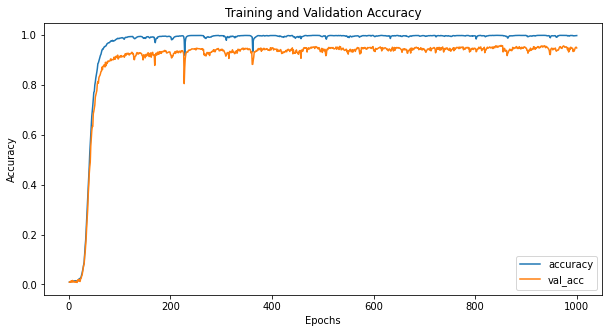

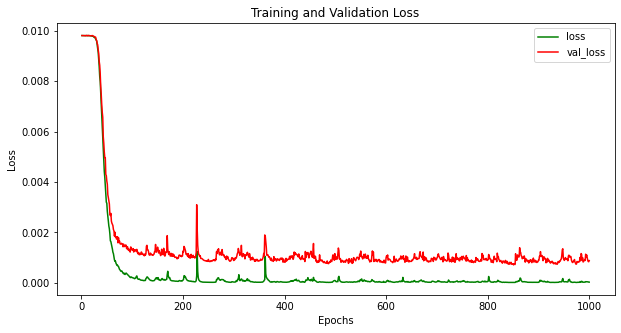

In [ ]:
history=history.history
epochs = range(1, len(history['loss']) + 1)
acc = history['accuracy']
loss = history['loss']
val_acc = history['val_accuracy']
val_loss = history['val_loss']

plt.figure(figsize=(10, 5))
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.plot(epochs, acc, label='accuracy')
plt.plot(epochs, val_acc, label='val_acc')
plt.legend()

plt.figure(figsize=(10, 5))
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.plot(epochs, loss, label='loss', color='g')
plt.plot(epochs, val_loss, label='val_loss', color='r')
plt.legend()


## 예측해보기(predict)

In [ ]:
y_pred = model.predict(X_test)

188/188 [==============================] - 3s 10ms/step


In [ ]:
y_test_p=pd.DataFrame(y_test)

for i in range(1,101):
  y_test_p.loc[y_test_p[i] == 1.0 , 'y_test'] = i  
y_test_p.y_test

0       75.0
1       90.0
2       67.0
3       91.0
4       84.0
        ... 
5995    44.0
5996    37.0
5997    99.0
5998    88.0
5999    31.0
Name: y_test, Length: 6000, dtype: float64

In [ ]:
ex=np.argmax(y_pred, axis=1)
ex=ex.astype('float64')
ex=pd.DataFrame(ex)
ex

,0
0,75.0
1,90.0
2,67.0
3,91.0
4,84.0
...,...
5995,44.0
5996,37.0
5997,99.0
5998,88.0


In [ ]:
ch1 = pd.DataFrame(np.rint(y_pred))
ch1['pred'] = ex
data_test.reset_index(inplace=True, drop=True)
predict = pd.concat([data_test,ch1['pred'], y_test_p['y_test']],axis = 1)

In [ ]:
predict['compare'] = np.where(predict['pred']==predict['y_test'],'yes', 'no')

In [ ]:
predict_1 = predict[predict["compare"]=='no']
predict_1

,0,1,2,3,4,5,6,7,8,9,...,249,250,251,252,253,254,255,pred,y_test,compare
8,0.034902,0.040244,0.046107,0.052067,0.057719,0.062743,0.066955,0.070322,0.072960,0.075095,...,0.085447,0.084625,0.083489,0.081097,0.076492,0.069015,0.058567,18.0,2.0,no
11,0.109717,0.110659,0.111964,0.114482,0.118950,0.125818,0.135116,0.146405,0.158831,0.171282,...,-0.046100,-0.047511,-0.047318,-0.046095,-0.044528,-0.043274,-0.042820,2.0,92.0,no
26,0.014270,0.001147,-0.009664,-0.017843,-0.023431,-0.026793,-0.028535,-0.029376,-0.030009,-0.030962,...,-0.023292,-0.026665,-0.030282,-0.033635,-0.035797,-0.035559,-0.031681,10.0,8.0,no
27,-0.030546,-0.028344,-0.027399,-0.027423,-0.028062,-0.029064,-0.030394,-0.032242,-0.034932,-0.038768,...,0.005832,0.002299,-0.006270,-0.020143,-0.038324,-0.058224,-0.075590,66.0,47.0,no
35,-0.025196,-0.024448,-0.023728,-0.023056,-0.022438,-0.021864,-0.021319,-0.020791,-0.020296,-0.019888,...,0.045220,0.041943,0.036367,0.029059,0.020812,0.012487,0.004854,96.0,8.0,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5904,-0.023422,-0.018496,-0.014607,-0.011922,-0.010307,-0.009338,-0.008411,-0.006905,-0.004374,-0.000691,...,-0.045415,-0.049928,-0.055818,-0.062579,-0.069229,-0.074560,-0.077474,18.0,94.0,no
5911,0.031127,0.030208,0.029620,0.029588,0.030140,0.031080,0.032028,0.032515,0.032121,0.030616,...,-0.026762,-0.027985,-0.028425,-0.028331,-0.027923,-0.027419,-0.027036,95.0,49.0,no
5943,0.063536,0.071162,0.078900,0.086882,0.095225,0.103941,0.112881,0.121710,0.129939,0.136985,...,-0.053988,-0.052298,-0.050341,-0.048330,-0.046442,-0.044802,-0.043505,29.0,42.0,no
5972,-0.043211,-0.041627,-0.039691,-0.037799,-0.036304,-0.035467,-0.035429,-0.036219,-0.037772,-0.039970,...,-0.225394,-0.183337,-0.113905,-0.020055,0.090091,0.203977,0.306470,39.0,30.0,no
